Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 5236 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Mapping das classes: {'NORMAL': 0, 'PNEUMONIA': 1}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Modelo carregado de /content/drive/MyDrive/RV/Projeto/modelo_pneumoniav6.h5
20/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.8497 - loss: 0.5182 - precision_1: 0.5016
Test Loss: 0.3512
Test Accuracy: 0.8942
Test Precision: 0.8857
20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step

Relatório de Classificação:
              precision    recall  f1-score   support

      Normal       0.91      0.79      0.85       234
   Pneumonia       0.89      0.95      0.92       390

    accuracy                           0.89       624
   macro avg       0.90      0.87      0.88       624
weighted avg       0.90      0.89      0.89       624



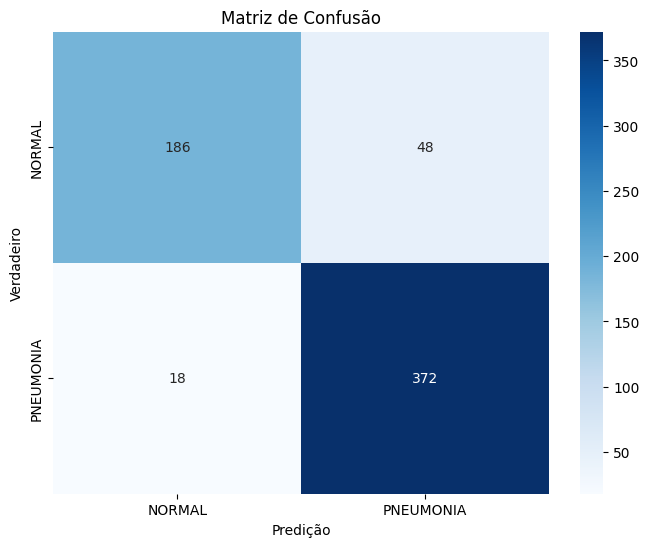

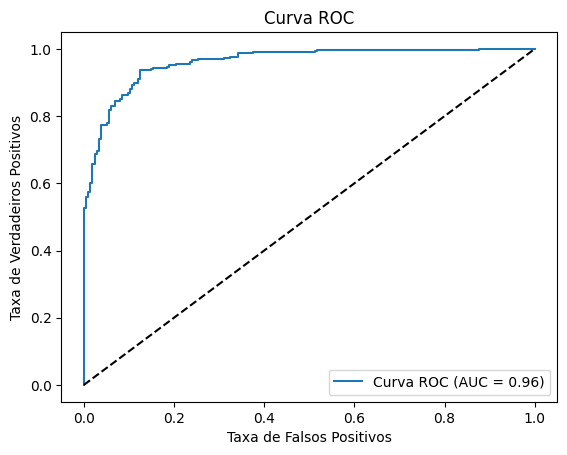

Última camada convolucional: Conv_1
Mapping de classes: {'NORMAL': 0, 'PNEUMONIA': 1}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


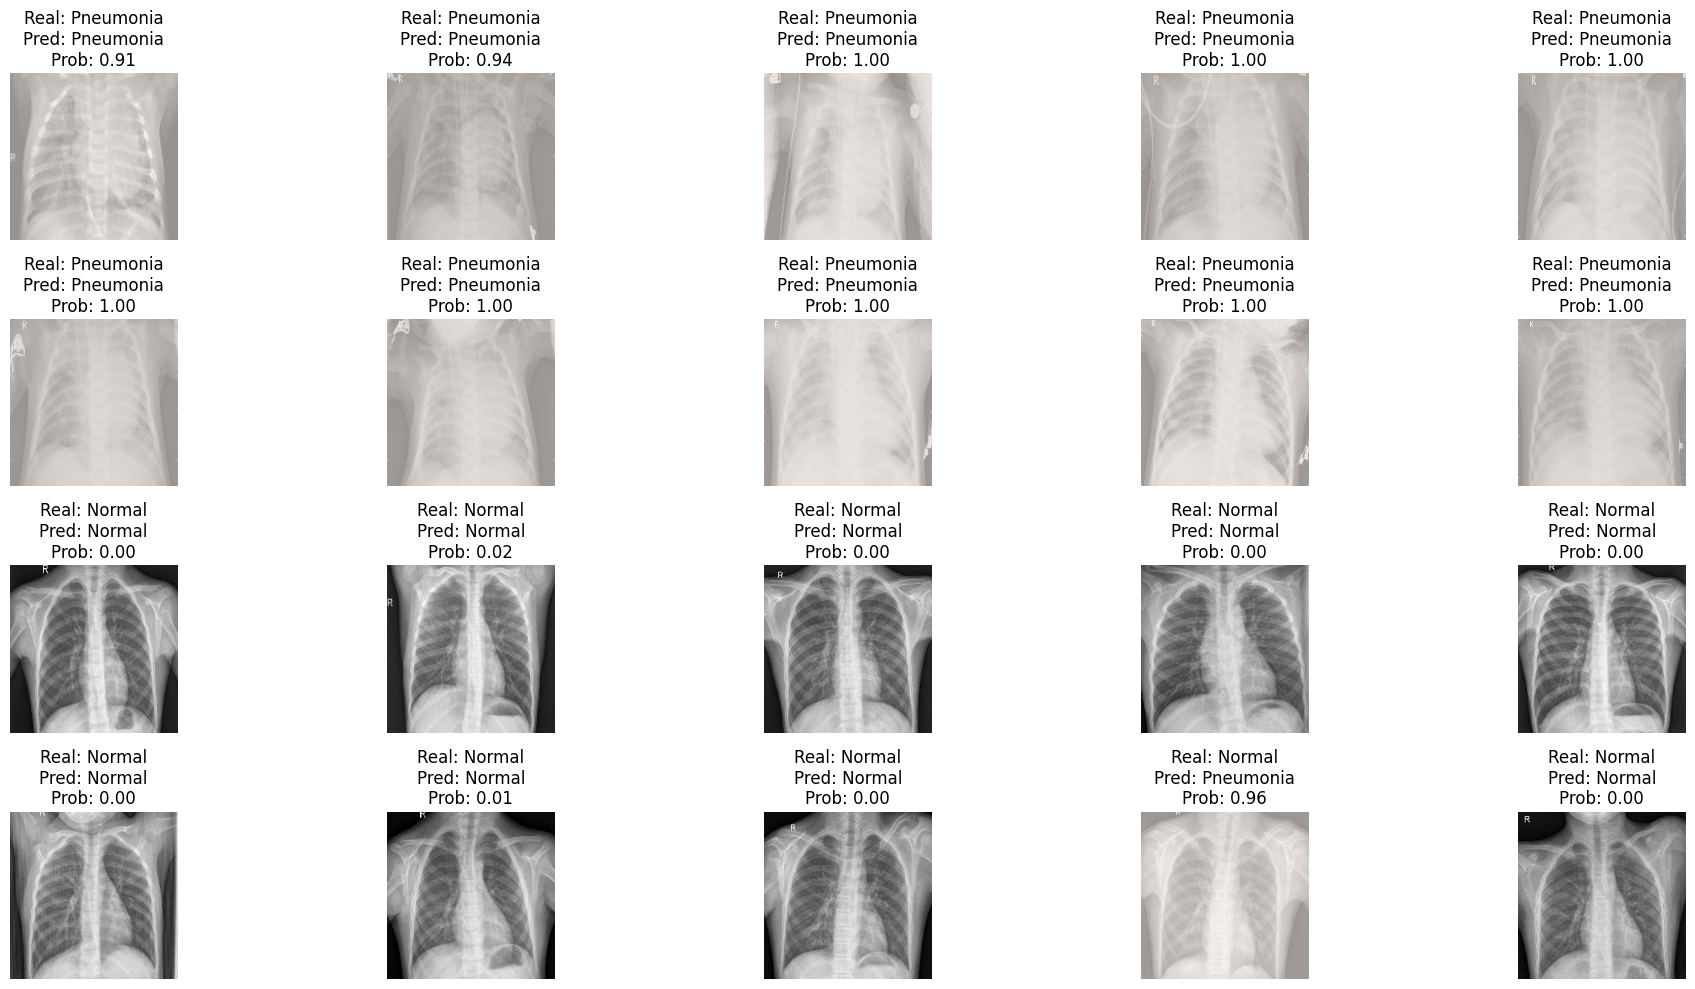

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import seaborn as sns

train_dir = '/content/drive/MyDrive/RV/Projeto/train'
val_dir   = '/content/drive/MyDrive/RV/Projeto/val'
test_dir  = '/content/drive/MyDrive/RV/Projeto/test'
model_path = '/content/drive/MyDrive/RV/Projeto/modelo_pneumoniav6.h5'

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Mapping das classes:", train_generator.class_indices)

def build_model(image_size):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(image_size[0], image_size[1], 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = False

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output)
    return model, base_model

if os.path.exists(model_path):
    model = tf.keras.models.load_model(model_path)
    print("Modelo carregado de", model_path)
    history = None
    history_fine = None
else:
    model, base_model = build_model(image_size)
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])
    model.summary()

    epochs_initial = 20
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs_initial
    )

    base_model.trainable = True
    for layer in base_model.layers[:-20]:
         layer.trainable = False

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision()])

    fine_tune_epochs = 20
    history_fine = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=fine_tune_epochs
    )

    model.save(model_path)
    print("Modelo salvo em", model_path)

if history is not None:
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if history_fine is not None:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

    total_epochs = len(acc)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(total_epochs), acc, label='Acurácia Treinamento')
    plt.plot(range(total_epochs), val_acc, label='Acurácia Validação')
    plt.title('Acurácia ao longo das épocas')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(total_epochs), loss, label='Perda Treinamento')
    plt.plot(range(total_epochs), val_loss, label='Perda Validação')
    plt.title('Perda ao longo das épocas')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    plt.show()

test_loss, test_acc, test_precision = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")

test_generator.reset()
preds = model.predict(test_generator)
preds_binary = (preds > 0.5).astype(int).reshape(-1)
true_labels = test_generator.classes

print("\nRelatório de Classificação:")
print(classification_report(true_labels, preds_binary, target_names=["Normal", "Pneumonia"]))

conf_mat = confusion_matrix(true_labels, preds_binary)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel("Predição")
plt.ylabel("Verdadeiro")
plt.title("Matriz de Confusão")
plt.show()

fpr, tpr, thresholds = roc_curve(true_labels, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

def get_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Nenhuma camada convolucional encontrada no modelo.")

try:
    last_conv_layer_name = get_last_conv_layer(model.get_layer('mobilenetv2_1.00_224'))
except Exception as e:
    last_conv_layer_name = get_last_conv_layer(model)
print("Última camada convolucional:", last_conv_layer_name)

def make_gradcam_plus_plus_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
                conv_outputs, predictions = grad_model(img_array)
                loss = predictions[:, 0]

            first_grads = tape3.gradient(loss, conv_outputs)
        second_grads = tape2.gradient(first_grads, conv_outputs)

    third_grads = tape1.gradient(second_grads, conv_outputs)
    global_sum = tf.reduce_sum(conv_outputs, axis=(0, 1, 2))
    alpha_num = second_grads
    alpha_denom = 2 * second_grads + third_grads * conv_outputs
    alpha_denom = tf.where(alpha_denom != 0.0, alpha_denom, tf.ones_like(alpha_denom))
    alphas = alpha_num / alpha_denom
    alphas_thresholding = tf.nn.relu(alphas)
    weights = tf.reduce_sum(alphas_thresholding * tf.nn.relu(first_grads), axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(weights * conv_outputs, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    heatmap = heatmap ** 0.5
    return heatmap.numpy()

def overlay_heatmap(heatmap, img, alpha=0.4, colormap=plt.cm.Reds):
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(np.expand_dims(heatmap, axis=-1), (img.shape[0], img.shape[1])).numpy()
    heatmap = np.squeeze(heatmap)
    heatmap_color = colormap(heatmap)
    heatmap_color = np.uint8(255 * heatmap_color[:, :, :3])
    superimposed_img = img * (1 - alpha) + heatmap_color * alpha
    superimposed_img = np.clip(superimposed_img, 0, 255)
    return np.uint8(superimposed_img)

print("Mapping de classes:", test_generator.class_indices)

pneumonia_indices = [i for i, label in enumerate(test_generator.classes) if label == 1][:10]
normal_indices = [i for i, label in enumerate(test_generator.classes) if label == 0][:10]
selected_indices = pneumonia_indices + normal_indices

plt.figure(figsize=(20, 10))
for i, idx in enumerate(selected_indices):
    img_path = os.path.join(test_dir, test_generator.filenames[idx])
    img = load_img(img_path, target_size=image_size)
    img_array = img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

    pred_prob = model.predict(img_array_expanded)[0][0]
    pred_label = "Pneumonia" if pred_prob > 0.5 else "Normal"
    true_label = "Pneumonia" if test_generator.classes[idx] == 1 else "Normal"

    if pred_label == "Pneumonia":
        heatmap = make_gradcam_plus_plus_heatmap(img_array_expanded, model, last_conv_layer_name)
        original_img = img_to_array(load_img(img_path, target_size=image_size))
        display_img = overlay_heatmap(heatmap, original_img, alpha=0.6, colormap=plt.cm.Reds)
    else:
        display_img = img_to_array(load_img(img_path, target_size=image_size))

    plt.subplot(4, 5, i + 1)
    plt.imshow(display_img.astype('uint8'))
    plt.title(f"Real: {true_label}\nPred: {pred_label}\nProb: {pred_prob:.2f}")
    plt.axis('off')
plt.tight_layout()
plt.show()